# Cluster analysis

In [1]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import shutil

df_latlon=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/Magni-PCR-GLOBWB-RF-NEW/source/data/stationLatLon.csv')

In [2]:
def merge_csv_with_filename(path, output_file):
    # Get all CSV files in the directory
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    
    # Create an empty list to store the dataframes
    dfs = []
    
    # Iterate over each CSV file
    for file in csv_files:
        # Read the CSV file and extract the filename
        filename = os.path.basename(file)
        df = pd.read_csv(file)
        df['Filename'] = filename
        dfs.append(df)
    
    # Concatenate all dataframes into one
    bigtable = pd.concat(dfs)
    
    # Check for NaN values
    print('Amount of NaNs:', bigtable['obs'].isnull().sum())
    
    # Save the merged dataframe as a CSV
    bigtable.to_csv(output_file, index=False)
    
    # Print the total number of rows
    print('Total rows:', len(bigtable))

# Define the path to the folder containing the CSV files
path = "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/Magni-PCR-GLOBWB-RF-NEW/source/data/predictors/pcr_allpredictors_ALL_low/"
output_file = "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_ALL_low.csv"

# Call the function to merge the CSV files and add the filename column
merge_csv_with_filename(path, output_file)

Amount of NaNs: 62431
Total rows: 145523


In [3]:
bigtable=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_ALL_low.csv')
bigtable['Filename']= bigtable['Filename'].str.replace('pcr_allpredictors_|.csv', '', regex=True)
bigtable=bigtable.groupby(['Filename']).mean()
bigtable=bigtable.drop(['obs'], axis=1)

# to only choose specific columns
bigtable=bigtable[['pcr','satWC1','airEntry1','aridityIdx','slopeLength','tanSlope','storLowTotal','gwRecharge','bankWidth','temperature','referencePotET']]

bigtable.head()

,pcr,satWC1,airEntry1,aridityIdx,slopeLength,tanSlope,storLowTotal,gwRecharge,bankWidth,temperature,referencePotET
Filename,,,,,,,,,,,
1104150,0.000271,-0.240589,0.513546,-0.936129,0.282999,0.399654,-2.360352e-16,6.521432e-17,0.378078,-1.615690e-16,1.760110e-17
1112110,0.003175,-0.209140,0.279197,-0.747552,0.209632,-0.430450,6.769653e-18,2.482206e-18,2.697908,3.199789e-16,3.046344e-18
1112320,0.000034,-0.119127,0.673510,-0.740682,0.221834,-0.499236,2.303938e-16,-2.066436e-16,1.560845,-8.642590e-17,-2.645101e-16
1112330,0.000160,0.040954,0.504668,-0.572802,-0.042737,-0.468003,1.308800e-17,5.878315e-17,2.228899,-3.703000e-16,1.258591e-16
1112340,0.000521,0.040954,0.504668,-0.572802,-0.042737,-0.468003,-7.757140e-02,-1.789006e-01,2.228899,2.005266e-02,1.882611e-02


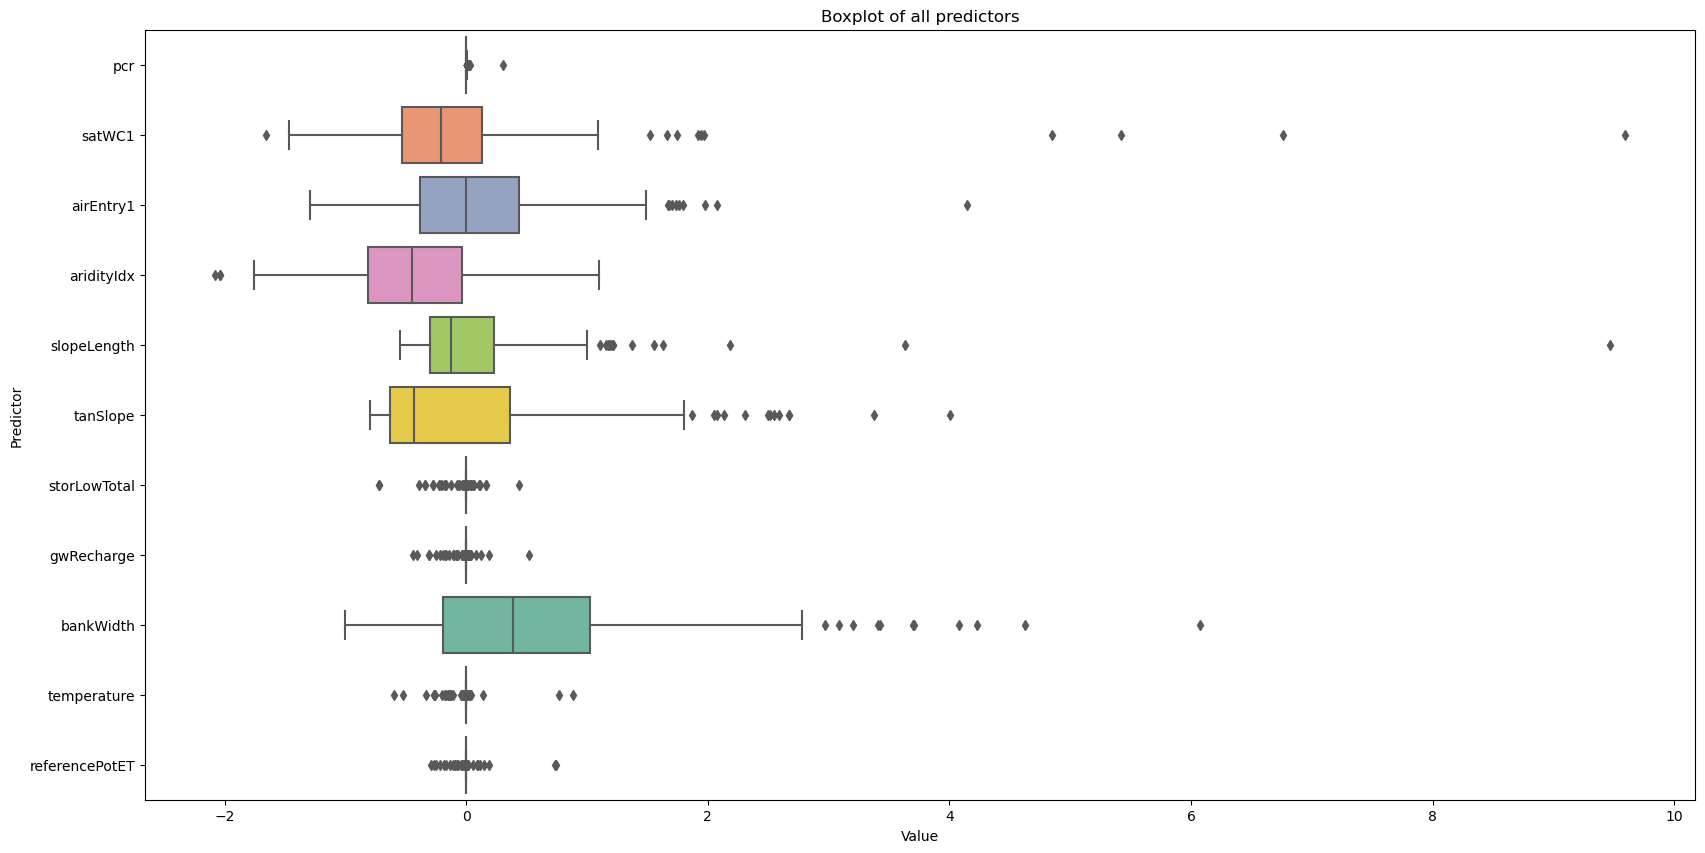

In [4]:
# boxplot of all bigtable predictors
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=bigtable, orient="h", palette="Set2")
plt.title('Boxplot of all predictors')
plt.xlabel('Value')
plt.ylabel('Predictor')
plt.show()

Original shape:  (321, 11)
PCA shape:       (321, 5)


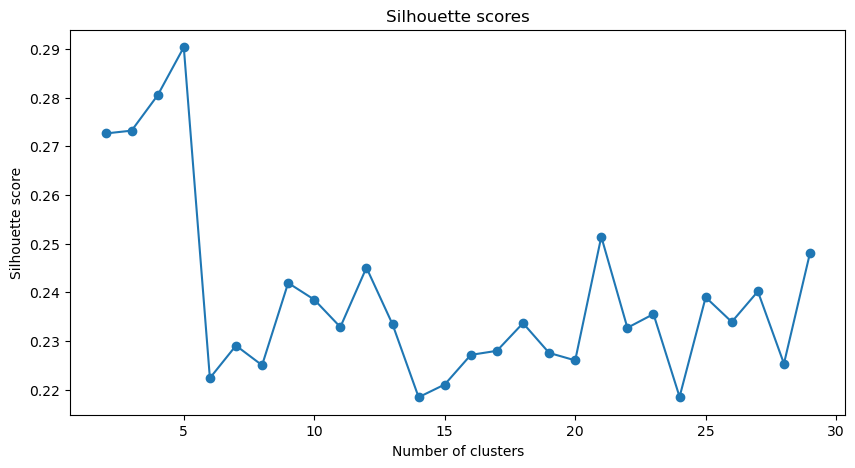

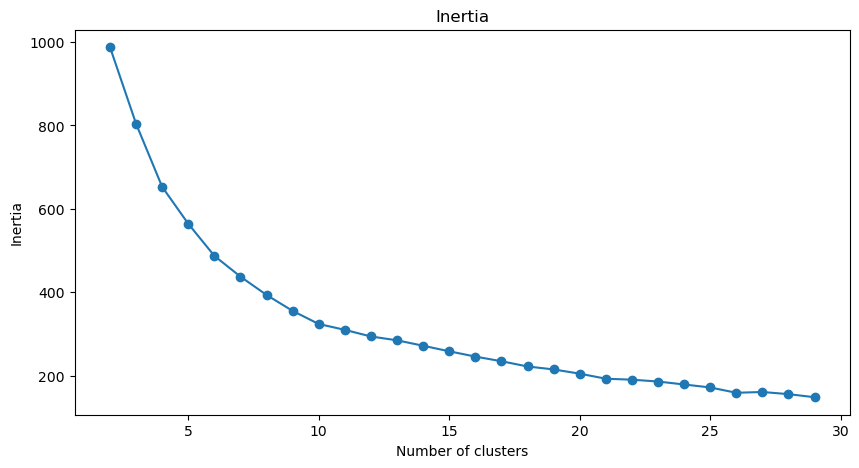

In [5]:
# first use the PCA to reduce the amount of predictors
# define the amount of components
pca = PCA(n_components=0.95)
pca.fit(bigtable)
# transform the data
bigtable_pca = pca.transform(bigtable)
# check the shape
print('Original shape: ', bigtable.shape)
print('PCA shape:      ', bigtable_pca.shape)

# find the optimal amount of clusters
range_n_clusters = range(2, 30)

# create empty lists to store the results
silhouette_scores = []
silhouette_sample = []

# iterate through the range of clusters
for n_clusters in range_n_clusters:
    # create the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    # fit the clusterer
    cluster_labels = clusterer.fit_predict(bigtable_pca)
    # calculate the silhouette score
    silhouette_avg = silhouette_score(bigtable_pca, cluster_labels)
    # calculate the silhouette sample
    sample_silhouette_values = silhouette_samples(bigtable_pca, cluster_labels)
    # append the results to the lists
    silhouette_scores.append(silhouette_avg)
    silhouette_sample.append(sample_silhouette_values)

# plot the silhouette scores
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# also check with the elbow method
inertia = []

# iterate through the range of clusters
for n_clusters in range_n_clusters:
    # create the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    # fit the clusterer
    cluster_labels = clusterer.fit_predict(bigtable_pca)
    # calculate the inertia
    inertia.append(clusterer.inertia_)

# plot the inertia
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/var/folders/cy/m0ghrt5529lf66_4rgd0s2mw0000gn/T/ipykernel_24202/542939118.py:43: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


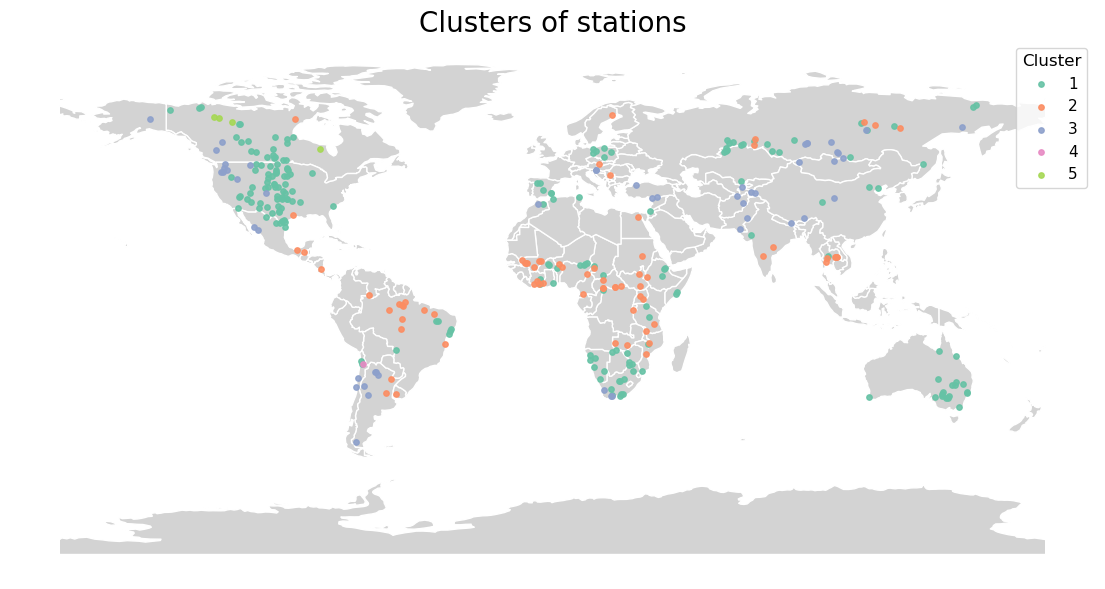

In [27]:
# use 13 clusters
# create the clusterer
clusterer = KMeans(n_clusters=5, random_state=42)
# fit the clusterer
cluster_labels = clusterer.fit_predict(bigtable_pca)
# add the cluster labels to the dataframe
bigtable['Cluster'] = cluster_labels
bigtable.head()

only_clusters = bigtable[['Cluster']]
# because df is grouped by filename, it is not a row anymore, but a groupby object
# so we need to reset the index
only_clusters = only_clusters.reset_index()
only_clusters['Filename'] = only_clusters['Filename'].astype(int)
only_clusters.head()



# inner join the latlon data with the cluster data
cluster_info = pd.merge(only_clusters, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
cluster_info.head()

# Set the color palette
sns.set_palette("Set2")

# Set the marker size
marker_size = 9.5

# Create a geodataframe
gdf = gpd.GeoDataFrame(cluster_info, geometry=gpd.points_from_xy(cluster_info.lon, cluster_info.lat))
# Set the coordinate reference system (CRS) to WGS84
gdf.crs = 'epsg:4326'

# Define a list of distinct colors for clusters
num_clusters = len(gdf['Cluster'].unique())
colors = sns.color_palette("Set2", num_clusters)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Clusters of stations', fontsize=20)

# Add a basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot the clusters on top of the basemap
for cluster, color in zip(gdf['Cluster'].unique(), colors):
    gdf[gdf['Cluster'] == cluster].plot(ax=ax, color=color, alpha=0.9, markersize=15)

# Set the aspect ratio based on the map's bounding box
ax.set_aspect('auto')
ax.legend([1,2,3,4,5], title='Cluster', loc='best', fontsize=11, title_fontsize=12)

# Remove x and y axis
ax.set_axis_off()

plt.show()

In [7]:
cluster_info.Cluster.value_counts()

2    194
1     71
0     51
4      4
3      1
Name: Cluster, dtype: int64

In [8]:
# only rows with cluster 2
cluster2=cluster_info[cluster_info['Cluster'] == 2]

only_filename = cluster2[['Filename']]
only_filename = only_filename.reset_index()
only_filename = only_filename.drop(['index'], axis=1)
# add path and .csv to the filename
only_filename['Filename'] = only_filename['Filename'].astype(str)
path='pcr_allpredictors_'
only_filename['Filename'] = only_filename['Filename'].apply(lambda x: path + x + '.csv')
only_filename.head()
# show content of first row
only_filename['Filename'][0]

'pcr_allpredictors_1104150.csv'

In [9]:
# folder with all stations
folder= "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/pcr_allpredictors/"
# folder to save the stations in cluster 2
folder2= "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/cluster2/"

# loop through all files in the folder
for filename in os.listdir(folder):
    # check if the file is in the cluster 2 list
    if filename in only_filename['Filename'].astype(str).values:
        # if so, copy the file to the folder2
        shutil.copy(folder + filename, folder2 + filename)
    else:
        pass

In [10]:
# randomly shuffle all stations and put 70% in one dataframe and 30% in another dataframe
# folder with all stations
folder= "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/cluster2/"
# folder to save the bigtables in
folder2= "/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/"

# create an empty list
filenames = []
# loop through all files in the folder
for filename in os.listdir(folder):
    # append the filename to the list
    filenames.append(filename)

# shuffle the filenames, but set seed to 42 so it is reproducible
random.seed(42)
random.shuffle(filenames)

# split the filenames into a train and test set
train_filenames = filenames[:int(len(filenames)*0.7)]
test_filenames = filenames[int(len(filenames)*0.7):]

# create a dataframe with the train filenames
df_train_filenames = pd.DataFrame(train_filenames, columns=['Filename'])
# create a dataframe with the test filenames
df_test_filenames = pd.DataFrame(test_filenames, columns=['Filename'])
import math

df_test = pd.DataFrame()
count_test = 0

for filename in os.listdir(folder):
    if filename in df_test_filenames['Filename'].astype(str).values:
        temp_df = pd.read_csv(folder + filename)
        temp_df['Filename'] = filename
        temp_df['Filename'] = temp_df['Filename'].str.replace('.csv', '', regex=True)
        temp_df['Filename'] = temp_df['Filename'].str.replace('pcr_allpredictors_', '', regex=True)
        temp_df = temp_df.dropna()
        
        table_size = int(len(temp_df) // 60) * 60  # Round down to nearest multiple of 60
        if table_size >= 60:
            temp_df = temp_df[:table_size]
            df_test = pd.concat([df_test, temp_df])
        else:
            count_test += 1
    else:
        pass

print('Catchments not in test:', count_test)

df_train = pd.DataFrame()
count_train = 0

for filename in os.listdir(folder):
    if filename in df_train_filenames['Filename'].astype(str).values:
        temp_df = pd.read_csv(folder + filename)
        # add a column with the filename
        temp_df['Filename'] = filename
        temp_df['Filename'] = temp_df['Filename'].str.replace('.csv', '', regex=True)
        temp_df['Filename'] = temp_df['Filename'].str.replace('pcr_allpredictors_', '', regex=True)
        temp_df = temp_df.dropna()

        table_size = int(len(temp_df) // 60) * 60  # Round down to nearest multiple of 60
        if len(temp_df) > 60:
            temp_df = temp_df[:table_size]
            df_train = pd.concat([df_train, temp_df])
        else:
            count_train += 1
    else:
        pass

print('Catchments skipped in train:', count_train)

# save the train and test bigtables
df_train.to_csv(folder2 + 'train_cluster2.csv', index=False)
df_test.to_csv(folder2 + 'test_cluster2.csv', index=False)

Catchments not in test: 5
Catchments skipped in train: 16
